# NASNet Training

In [1]:
#Here we have all the packages needed to create our Neural Net
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D,AveragePooling2D,Input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
import time
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import itertools
import h5py
from keras.utils.io_utils import HDF5Matrix
from keras.models import Model
from keras.optimizers import Adam
from keras.models import model_from_json

Using TensorFlow backend.


In [2]:
def save_model(name_json, name_weights,model):
    model_json=model.to_json()
    with open(name_json,'w') as json_file:
        json_file.write(model_json)
    model.save_weights(name_weights)
    print('saved model to disk')

In [3]:
#load json and create model
def load_model(name_json,name_weights):
    json_file=open(name_json,'r')
    loaded_model_json=json_file.read()
    json_file.close()
    loaded_model=model_from_json(loaded_model_json)
    #load weights into new model
    loaded_model.load_weights(name_weights)
    print('Loaded model from disk')
    return loaded_model

# Load Data (Start here)

In [4]:
train_image_dir='output/train'
val_image_dir='output/val'
test_image_dir='output/test'
image_size=(331,331)
batch_size=8

## Create Unaugmented data generator

In [5]:
datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = False,
fill_mode = "nearest",
zoom_range = 0,
width_shift_range = 0,
height_shift_range=0,
rotation_range=0)

train_generator = datagen.flow_from_directory(
train_image_dir,
target_size = (image_size[0], image_size[1]),
batch_size = batch_size, 
class_mode = "categorical")

val_generator = datagen.flow_from_directory(
val_image_dir,
target_size = (image_size[0], image_size[1]),
batch_size = batch_size, 
class_mode = "categorical")

test_generator = datagen.flow_from_directory(
test_image_dir,
target_size = (image_size[0], image_size[1]),
batch_size = batch_size, 
class_mode = "categorical")

Found 80800 images belonging to 101 classes.
Found 10100 images belonging to 101 classes.
Found 10100 images belonging to 101 classes.


## Look at some of the images 

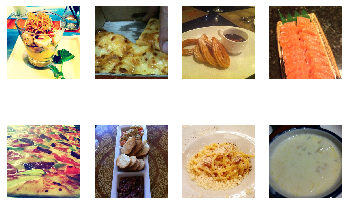

In [12]:
from skimage import io
def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y=train_generator.next()
for i in range(0,8):
    image=x[i]
    plt.subplot(2,4,i+1)
    plt.imshow(image)
    plt.axis('off')

## augmented data generator

In [6]:
aug_gen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = False,
fill_mode = "nearest",
zoom_range = 0.25,
width_shift_range = 0.2,
height_shift_range=0.2,
rotation_range=30)

a_train_generator = aug_gen.flow_from_directory(
train_image_dir,
target_size = (image_size[0], image_size[1]),
batch_size = batch_size, 
class_mode = "categorical")

Found 80800 images belonging to 101 classes.


## Load NASNet (Base) Model

In [5]:
from keras.applications.nasnet import NASNetLarge

In [8]:
base_model=NASNetLarge(weights='imagenet',include_top=False,input_tensor=Input(shape=(331,331,3),name='input_image'),classes=101)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
dropout = .5 #Choose dropout rate
x=base_model.output
x=GlobalAveragePooling2D()(x)
# x=Flatten()(x)
x=Dense(1024,activation='relu')(x)
x = Dropout(rate = dropout, name = 'dropout1')(x)
x=Dense(1024,activation='relu')(x)
x = Dropout(rate = dropout, name = 'dropout2')(x)
x=Dense(512,activation='relu')(x)
predictions=Dense(101,activation='softmax')(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
nas_net_1=Model(inputs=base_model.input,outputs=predictions)

In [11]:
nas_net_1.compile(optimizer=Adam(lr=.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
nas_net_1.fit_generator(train_generator,
               steps_per_epoch=len(train_generator),
               epochs=1,
               verbose=1,
               validation_data=val_generator,
               validation_steps=len(val_generator),
               shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
10100/10100 [==============================] - 9791s 969ms/step - loss: 2.0511 - acc: 0.5086 - val_loss: 1.5807 - val_acc: 0.6645


In [13]:
save_model('nas_net_1.json','nas_net_1_weights.h5',nas_net_1)

saved model to disk


In [14]:
nas_net_1.fit_generator(train_generator,
               steps_per_epoch=len(train_generator),
               epochs=5,
               verbose=1,
               validation_data=val_generator,
               validation_steps=len(val_generator),
               shuffle=True)

Epoch 1/5
10100/10100 [==============================] - 9699s 960ms/step - loss: 1.0739 - acc: 0.7340 - val_loss: 1.2998 - val_acc: 0.7209
Epoch 2/5
10100/10100 [==============================] - 9698s 960ms/step - loss: 0.8055 - acc: 0.7985 - val_loss: 1.2850 - val_acc: 0.7320
Epoch 3/5
  615/10100 [>.............................] - ETA: 2:28:18 - loss: 0.5878 - acc: 0.8504

KeyboardInterrupt: 

In [15]:
save_model('nas_net_1_1.json','nas_net_1_1_weights.h5',nas_net_1)

saved model to disk


In [8]:
nas_net_1=load_model('nas_net_1_1.json','nas_net_1_1_weights.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk


In [10]:
nas_net_1.compile(optimizer=Adam(lr=.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
nas_net_1.fit_generator(train_generator,
               steps_per_epoch=len(train_generator),
               epochs=2,
               verbose=1,
               validation_data=val_generator,
               validation_steps=len(val_generator),
               shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
10100/10100 [==============================] - 9773s 968ms/step - loss: 0.6483 - acc: 0.8354 - val_loss: 1.2817 - val_acc: 0.7309
Epoch 2/2
10100/10100 [==============================] - 9661s 957ms/step - loss: 0.5443 - acc: 0.8626 - val_loss: 1.1976 - val_acc: 0.7519


In [12]:
save_model('nas_net_1_2.json','nas_net_1_2_weights.h5',nas_net_1)

saved model to disk


## Model with data augmentation 

In [1]:
nas_net_2=load_model('nas_net_1_2.json','nas_net_1_2_weights.h5')

In [8]:
nas_net_2.compile(optimizer=Adam(lr=.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [9]:
nas_net_2.fit_generator(a_train_generator,
               steps_per_epoch=len(a_train_generator),
               epochs=3,
               verbose=1,
               validation_data=val_generator,
               validation_steps=len(val_generator),
               shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
10100/10100 [==============================] - 9773s 968ms/step - loss: 0.8060 - acc: 0.8006 - val_loss: 1.2601 - val_acc: 0.7354
Epoch 2/3
10100/10100 [==============================] - 9664s 957ms/step - loss: 0.7264 - acc: 0.8182 - val_loss: 1.1355 - val_acc: 0.7571
Epoch 3/3
10100/10100 [==============================] - 9681s 958ms/step - loss: 0.6681 - acc: 0.8304 - val_loss: 1.1098 - val_acc: 0.7540


In [11]:
save_model('nas_net_2.json','nas_net_2_weights.h5',nas_net_2)

saved model to disk


In [8]:
nas_net_3=load_model('nas_net_2.json','nas_net_2_weights.h5')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk


In [9]:
nas_net_3.compile(optimizer=Adam(lr=.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
nas_net_3.fit_generator(a_train_generator,
               steps_per_epoch=len(a_train_generator),
               epochs=3,
               verbose=1,
               validation_data=val_generator,
               validation_steps=len(val_generator),
               shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
10100/10100 [==============================] - 9746s 965ms/step - loss: 0.6272 - acc: 0.8424 - val_loss: 1.1112 - val_acc: 0.7627
Epoch 2/3
10100/10100 [==============================] - 9632s 954ms/step - loss: 0.5808 - acc: 0.8528 - val_loss: 1.0749 - val_acc: 0.7787
Epoch 3/3
10100/10100 [==============================] - 9636s 954ms/step - loss: 0.5423 - acc: 0.8601 - val_loss: 1.0889 - val_acc: 0.7821


In [11]:
save_model('nas_net_3.json','nas_net_3_weights.h5',nas_net_3)

saved model to disk
